## Adversarial Patches
Class: AIPI 590
Javidan Karimli

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1tnOBzL3YR4Nf8_XgBNNm4JW60z0T6iNH?usp=sharing)


This notebook implements adversarial patch techniques that aim to fool a ResNet classifier. By learning and applying small image patches, we show how a model can be made to misclassify an input as a completely different class. The code includes preprocessing consistent with ImageNet, expectation-over-transformation (EOT) for robustness, and utilities to train, save, and test patches on custom photos



In [33]:
## Standard libraries
import os
import json
import math
import time
import numpy as np
import scipy.linalg
from PIL import Image

## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgb
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.set()

## Progress bar
from tqdm.notebook import tqdm

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
# Torchvision
import torchvision
from torchvision.datasets import CIFAR10
from torchvision import transforms
# PyTorch Lightning
try:
    import pytorch_lightning as pl
except ModuleNotFoundError: # Google Colab does not have PyTorch Lightning installed by default. Hence, we do it here if necessary
    !pip install --quiet pytorch-lightning>=1.4
    import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint

# Path to the folder where the datasets are/should be downloaded (e.g. MNIST)
DATASET_PATH = "../data"
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "../saved_models/tutorial10"

# Setting the seed
pl.seed_everything(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Fetching the device that will be used throughout this notebook
device = torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda:0")
print("Using device", device)

/tmp/ipython-input-3344747636.py:14: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf') # For export
INFO:lightning_fabric.utilities.seed:Seed set to 42


Using device cuda:0


This code above sets up the environment for training and experimenting with neural networks in Python. It imports standard libraries for math, file handling, and image processing, along with plotting tools like Matplotlib and Seaborn to visualize results. It also brings in PyTorch, Torchvision, and PyTorch Lightning

In [34]:
import urllib.request
from urllib.error import HTTPError
import zipfile
# Github URL where the dataset is stored for this tutorial
base_url = "https://raw.githubusercontent.com/phlippe/saved_models/main/tutorial10/"
# Files to download
pretrained_files = [(DATASET_PATH, "TinyImageNet.zip"), (CHECKPOINT_PATH, "patches.zip")]
# Create checkpoint path if it doesn't exist yet
os.makedirs(DATASET_PATH, exist_ok=True)
os.makedirs(CHECKPOINT_PATH, exist_ok=True)

# For each file, check whether it already exists. If not, try downloading it.
for dir_name, file_name in pretrained_files:
    file_path = os.path.join(dir_name, file_name)
    if not os.path.isfile(file_path):
        file_url = base_url + file_name
        print(f"Downloading {file_url}...")
        try:
            urllib.request.urlretrieve(file_url, file_path)
        except HTTPError as e:
            print("Something went wrong. Please try to download the file from the GDrive folder, or contact the author with the full output including the following error:\n", e)
        if file_name.endswith(".zip"):
            print("Unzipping file...")
            with zipfile.ZipFile(file_path, 'r') as zip_ref:
                zip_ref.extractall(file_path.rsplit("/",1)[0])

This code downloads the required dataset and pretrained model files from GitHub if they are not already available on the computer.

In [3]:
# Load CNN architecture pretrained on ImageNet
os.environ["TORCH_HOME"] = CHECKPOINT_PATH
pretrained_model = torchvision.models.resnet34(weights='IMAGENET1K_V1')
pretrained_model = pretrained_model.to(device)

# No gradients needed for the network
pretrained_model.eval()
for p in pretrained_model.parameters():
    p.requires_grad = False

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to ../saved_models/tutorial10/hub/checkpoints/resnet34-b627a593.pth


100%|██████████| 83.3M/83.3M [00:00<00:00, 234MB/s]


In [35]:
# Mean and Std from ImageNet
NORM_MEAN = np.array([0.485, 0.456, 0.406])
NORM_STD = np.array([0.229, 0.224, 0.225])
# No resizing and center crop necessary as images are already preprocessed.
plain_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=NORM_MEAN,
                         std=NORM_STD)
])

# Load dataset and create data loader
imagenet_path = os.path.join(DATASET_PATH, "TinyImageNet/")
assert os.path.isdir(imagenet_path), f"Could not find the ImageNet dataset at expected path \"{imagenet_path}\". " + \
                                     f"Please make sure to have downloaded the ImageNet dataset here, or change the {DATASET_PATH=} variable."
dataset = torchvision.datasets.ImageFolder(root=imagenet_path, transform=plain_transforms)
data_loader = data.DataLoader(dataset, batch_size=32, shuffle=False, drop_last=False, num_workers=8)

# Load label names to interpret the label numbers 0 to 999
with open(os.path.join(imagenet_path, "label_list.json"), "r") as f:
    label_names = json.load(f)

def get_label_index(lab_str):
    assert lab_str in label_names, f"Label \"{lab_str}\" not found. Check the spelling of the class."
    return label_names.index(lab_str)

Importing the TinyImageNet to test out our outputs

In [36]:
def eval_model(dataset_loader, img_func=None):
    tp, tp_5, counter = 0., 0., 0.
    for imgs, labels in tqdm(dataset_loader, desc="Validating..."):
        imgs = imgs.to(device)
        labels = labels.to(device)
        if img_func is not None:
            imgs = img_func(imgs, labels)
        with torch.no_grad():
            preds = pretrained_model(imgs)
        tp += (preds.argmax(dim=-1) == labels).sum()
        tp_5 += (preds.topk(5, dim=-1)[1] == labels[...,None]).any(dim=-1).sum()
        counter += preds.shape[0]
    acc = tp.float().item()/counter
    top5 = tp_5.float().item()/counter
    print(f"Top-1 error: {(100.0 * (1 - acc)):4.2f}%")
    print(f"Top-5 error: {(100.0 * (1 - top5)):4.2f}%")
    return acc, top5

In [6]:
# _ = eval_model(data_loader)

In [37]:
def show_prediction(img, label, pred, K=5, adv_img=None, noise=None):

    if isinstance(img, torch.Tensor):
        # Tensor image to numpy
        img = img.cpu().permute(1, 2, 0).numpy()
        img = (img * NORM_STD[None,None]) + NORM_MEAN[None,None]
        img = np.clip(img, a_min=0.0, a_max=1.0)
        label = label.item()

    # Plot on the left the image with the true label as title.
    # On the right, have a horizontal bar plot with the top k predictions including probabilities
    if noise is None or adv_img is None:
        fig, ax = plt.subplots(1, 2, figsize=(10,2), gridspec_kw={'width_ratios': [1, 1]})
    else:
        fig, ax = plt.subplots(1, 5, figsize=(12,2), gridspec_kw={'width_ratios': [1, 1, 1, 1, 2]})

    ax[0].imshow(img)
    ax[0].set_title(label_names[label])
    ax[0].axis('off')

    if adv_img is not None and noise is not None:
        # Visualize adversarial images
        adv_img = adv_img.cpu().permute(1, 2, 0).numpy()
        adv_img = (adv_img * NORM_STD[None,None]) + NORM_MEAN[None,None]
        adv_img = np.clip(adv_img, a_min=0.0, a_max=1.0)
        ax[1].imshow(adv_img)
        ax[1].set_title('Adversarial')
        ax[1].axis('off')
        # Visualize noise
        noise = noise.cpu().permute(1, 2, 0).numpy()
        noise = noise * 0.5 + 0.5 # Scale between 0 to 1
        ax[2].imshow(noise)
        ax[2].set_title('Noise')
        ax[2].axis('off')
        # buffer
        ax[3].axis('off')

    if abs(pred.sum().item() - 1.0) > 1e-4:
        pred = torch.softmax(pred, dim=-1)
    topk_vals, topk_idx = pred.topk(K, dim=-1)
    topk_vals, topk_idx = topk_vals.cpu().numpy(), topk_idx.cpu().numpy()
    ax[-1].barh(np.arange(K), topk_vals*100.0, align='center', color=["C0" if topk_idx[i]!=label else "C2" for i in range(K)])
    ax[-1].set_yticks(np.arange(K))
    ax[-1].set_yticklabels([label_names[c] for c in topk_idx])
    ax[-1].invert_yaxis()
    ax[-1].set_xlabel('Confidence')
    ax[-1].set_title('Predictions')

    plt.show()
    plt.close()

This function is used to identify and display the top five predicted categories for a given image. It helps evaluate how the model classifies an image, which becomes especially useful after applying adversarial patches to see whether the patch successfully changes the model’s predictions.

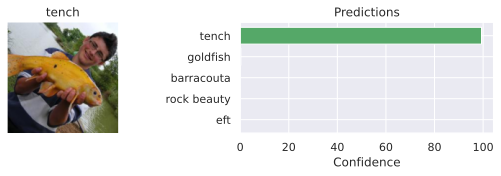

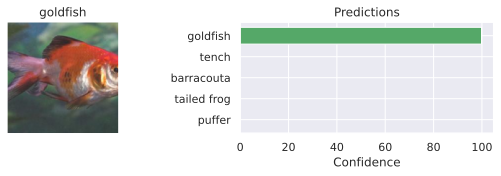

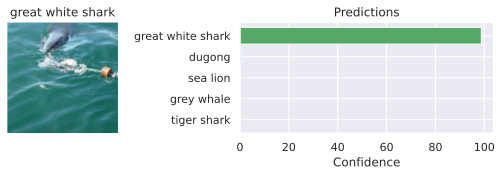

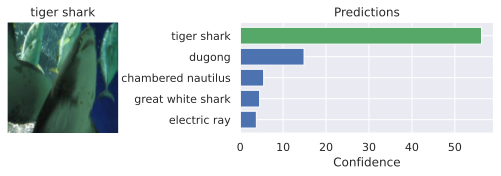

In [39]:
exmp_batch, label_batch = next(iter(data_loader))
with torch.no_grad():
    preds = pretrained_model(exmp_batch.to(device))
for i in range(1,17,5):
    show_prediction(exmp_batch[i], label_batch[i], preds[i])

In [40]:
def place_patch(img, patch):
    for i in range(img.shape[0]):
        h_offset = np.random.randint(0,img.shape[2]-patch.shape[1]-1)
        w_offset = np.random.randint(0,img.shape[3]-patch.shape[2]-1)
        img[i,:,h_offset:h_offset+patch.shape[1],w_offset:w_offset+patch.shape[2]] = patch_forward(patch)
    return img

Randomly placing the patch inside the image

In [41]:
TENSOR_MEANS, TENSOR_STD = torch.FloatTensor(NORM_MEAN)[:,None,None], torch.FloatTensor(NORM_STD)[:,None,None]
def patch_forward(patch):
    # Map patch values from [-infty,infty] to ImageNet min and max
    patch = (torch.tanh(patch) + 1 - 2 * TENSOR_MEANS) / (2 * TENSOR_STD)
    return patch

In [42]:
def eval_patch(model, patch, val_loader, target_class):
    model.eval()
    tp, tp_5, counter = 0., 0., 0.
    with torch.no_grad():
        for img, img_labels in tqdm(val_loader, desc="Validating...", leave=False):
            # For stability, place the patch at 4 random locations per image, and average the performance
            for _ in range(4):
                patch_img = place_patch(img, patch)
                patch_img = patch_img.to(device)
                img_labels = img_labels.to(device)
                pred = model(patch_img)
                # In the accuracy calculation, we need to exclude the images that are of our target class
                # as we would not "fool" the model into predicting those
                tp += torch.logical_and(pred.argmax(dim=-1) == target_class, img_labels != target_class).sum()
                tp_5 += torch.logical_and((pred.topk(5, dim=-1)[1] == target_class).any(dim=-1), img_labels != target_class).sum()
                counter += (img_labels != target_class).sum()
    acc = tp/counter
    top5 = tp_5/counter
    return acc, top5

Evaluation steps for the adverserial patched images to get the scores

In [44]:
def patch_attack(model, target_class, patch_size=64, num_epochs=5):
    # Leave a small set of images out to check generalization
    # In most of our experiments, the performance on the hold-out data points
    # was as good as on the training set. Overfitting was little possible due
    # to the small size of the patches.
    train_set, val_set = torch.utils.data.random_split(dataset, [4500, 500])
    train_loader = data.DataLoader(train_set, batch_size=32, shuffle=True, drop_last=True, num_workers=8)
    val_loader = data.DataLoader(val_set, batch_size=32, shuffle=False, drop_last=False, num_workers=4)

    # Create parameter and optimizer
    if not isinstance(patch_size, tuple):
        patch_size = (patch_size, patch_size)
    patch = nn.Parameter(torch.zeros(3, patch_size[0], patch_size[1]), requires_grad=True)
    optimizer = torch.optim.SGD([patch], lr=1e-1, momentum=0.8)
    loss_module = nn.CrossEntropyLoss()

    # Training loop
    for epoch in range(num_epochs):
        t = tqdm(train_loader, leave=False)
        for img, _ in t:
            img = place_patch(img, patch)
            img = img.to(device)
            pred = model(img)
            labels = torch.zeros(img.shape[0], device=pred.device, dtype=torch.long).fill_(target_class)
            loss = loss_module(pred, labels)
            optimizer.zero_grad()
            loss.mean().backward()
            optimizer.step()
            t.set_description(f"Epoch {epoch}, Loss: {loss.item():4.2f}")

    # Final validation
    acc, top5 = eval_patch(model, patch, val_loader, target_class)

    return patch.data, {"acc": acc.item(), "top5": top5.item()}

This function performs an adversarial patch attack to make a model misclassify images into a chosen target category. It first splits the dataset into training and validation sets to check how well the patch generalizes. A learnable patch parameter is created, and an optimizer is set up to update it during training. In each epoch, the patch is placed onto the training images, and the model’s predictions are compared with the desired target class using a loss function. The loss is then backpropagated to adjust the patch so it becomes more effective at fooling the model. After training, the function tests the final patch on the validation data to measure its accuracy and top-5 performance, returning both the optimized patch and its evaluation results.

In [45]:
# Load evaluation results of the pretrained patches
json_results_file = os.path.join(CHECKPOINT_PATH, "patch_results.json")
json_results = {}
if os.path.isfile(json_results_file):
    with open(json_results_file, "r") as f:
        json_results = json.load(f)

# If you train new patches, you can save the results via calling this function
def save_results(patch_dict):
    result_dict = {cname: {psize: [t.item() if isinstance(t, torch.Tensor) else t
                                   for t in patch_dict[cname][psize]["results"]]
                           for psize in patch_dict[cname]}
                   for cname in patch_dict}
    with open(os.path.join(CHECKPOINT_PATH, "patch_results.json"), "w") as f:
        json.dump(result_dict, f, indent=4)

In [46]:
def get_patches(class_names, patch_sizes):
    result_dict = dict()

    # Loop over all classes and patch sizes
    for name in class_names:
        result_dict[name] = dict()
        for patch_size in patch_sizes:
            c = label_names.index(name)
            file_name = os.path.join(CHECKPOINT_PATH, f"{name}_{patch_size}_patch.pt")
            # Load patch if pretrained file exists, otherwise start training
            if not os.path.isfile(file_name):
                patch, val_results = patch_attack(pretrained_model, target_class=c, patch_size=patch_size, num_epochs=5)
                print(f"Validation results for {name} and {patch_size}:", val_results)
                torch.save(patch, file_name)
            else:
                patch = torch.load(file_name)
            # Load evaluation results if exist, otherwise manually evaluate the patch
            if name in json_results:
                results = json_results[name][str(patch_size)]
            else:
                results = eval_patch(pretrained_model, patch, data_loader, target_class=c)

            # Store results and the patches in a dict for better access
            result_dict[name][patch_size] = {
                "results": results,
                "patch": patch
            }

    return result_dict

The code above builds and returns a dictionary of adversarial patches and their evaluation results for a list of class names and patch sizes. For each class and size it checks whether a pretrained patch file exists; if not, it trains a new patch with patch_attack and saves it to disk. It then either reads cached evaluation metrics from json_results or runs eval_patch to compute performance on a data loader, and finally stores both the patch tensor and its results under the class-and-size keys in the returned dictionary.

In [52]:
class_names = ['flamingo', 'killer whale', 'Chihuahua', 'Tibetan terrier', 'brown bear', 'American black bear', 'ice bear']#["trailer truck", 'school bus', 'plane', 'moving van']

patch_sizes = [64]

patch_dict = get_patches(class_names, patch_sizes)

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Validating...:   0%|          | 0/16 [00:00<?, ?it/s]

Validation results for flamingo and 64: {'acc': 0.9725000262260437, 'top5': 0.9994999766349792}


Validating...:   0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Validating...:   0%|          | 0/16 [00:00<?, ?it/s]

Validation results for killer whale and 64: {'acc': 0.9143286347389221, 'top5': 0.9824649095535278}


Validating...:   0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Validating...:   0%|          | 0/16 [00:00<?, ?it/s]

Validation results for Chihuahua and 64: {'acc': 0.9959999918937683, 'top5': 1.0}


Validating...:   0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Validating...:   0%|          | 0/16 [00:00<?, ?it/s]

Validation results for Tibetan terrier and 64: {'acc': 0.9860000014305115, 'top5': 0.9994999766349792}


Validating...:   0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Validating...:   0%|          | 0/16 [00:00<?, ?it/s]

Validation results for brown bear and 64: {'acc': 0.9804999828338623, 'top5': 0.9990000128746033}


Validating...:   0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Validating...:   0%|          | 0/16 [00:00<?, ?it/s]

Validation results for American black bear and 64: {'acc': 0.9884999990463257, 'top5': 0.9994999766349792}


Validating...:   0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Validating...:   0%|          | 0/16 [00:00<?, ?it/s]

Validation results for ice bear and 64: {'acc': 0.9799599051475525, 'top5': 0.9984970092773438}


Validating...:   0%|          | 0/157 [00:00<?, ?it/s]

Training the patches

Saved: saved_patches/flamingo_size64.png
Saved: saved_patches/killer whale_size64.png
Saved: saved_patches/Chihuahua_size64.png
Saved: saved_patches/Tibetan terrier_size64.png
Saved: saved_patches/brown bear_size64.png
Saved: saved_patches/American black bear_size64.png
Saved: saved_patches/ice bear_size64.png


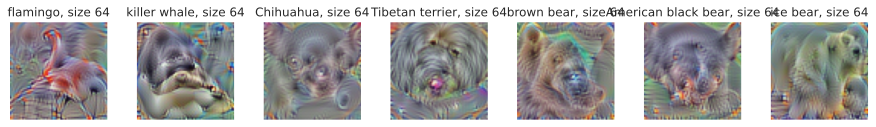

In [55]:
def show_patches():
    nrows = len(patch_sizes)
    ncols = len(class_names)
    fig, ax = plt.subplots(nrows, ncols, figsize=(ncols*2.2, nrows*2.2))

    # Normalize axes to 2D for consistent indexing
    if nrows == 1 and ncols == 1:
        axes = np.array([[ax]])
    elif nrows == 1:
        axes = np.array([ax])  # shape (1, ncols)
    elif ncols == 1:
        axes = np.array(ax).reshape(nrows, 1)  # shape (nrows, 1)
    else:
        axes = ax  # already 2D

    for c_idx, cname in enumerate(class_names):
        for p_idx, psize in enumerate(patch_sizes):
            patch = patch_dict[cname][psize]["patch"]
            patch = (torch.tanh(patch) + 1) / 2  # Parameter -> pixel values
            patch = patch.detach().cpu().permute(1, 2, 0).numpy()
            patch = np.clip(patch, 0.0, 1.0)

            axes[p_idx, c_idx].imshow(patch)
            axes[p_idx, c_idx].set_title(f"{cname}, size {psize}")
            axes[p_idx, c_idx].axis('off')

    fig.subplots_adjust(hspace=0.3, wspace=0.3)
    plt.show()

def save_patches(output_dir="saved_patches", display_size=64):

    os.makedirs(output_dir, exist_ok=True)

    for cname in class_names:
        for psize in patch_sizes:
            patch = patch_dict[cname][psize]["patch"]              # [C,H,W] torch
            patch = (torch.tanh(patch) + 1) / 2                    # [0,1]
            patch = patch.detach().cpu().permute(1, 2, 0).numpy()  # HWC
            patch = np.clip(patch, 0.0, 1.0)


            pil = Image.fromarray((patch * 255).astype(np.uint8)).convert("RGB")
            pil = pil.resize((display_size, display_size), Image.BICUBIC)

            save_path = os.path.join(output_dir, f"{cname}_size{psize}.png")
            pil.save(save_path, format="PNG", optimize=True)
            print(f"Saved: {save_path}")



save_patches()

show_patches()

Show and save the generated patches to a temporary folder so they can be previewed and downloaded later.

In [24]:
%%html
<!-- Some HTML code to increase font size in the following table -->
<style>
th {font-size: 120%;}
td {font-size: 120%;}
</style>

In [25]:
import tabulate
from IPython.display import display, HTML

def show_table(top_1=True):
    i = 0 if top_1 else 1
    table = [[name] + [f"{(100.0 * patch_dict[name][psize]['results'][i]):4.2f}%" for psize in patch_sizes]
             for name in class_names]
    display(HTML(tabulate.tabulate(table, tablefmt='html', headers=["Class name"] + [f"Patch size {psize}x{psize}" for psize in patch_sizes])))

In [56]:
show_table(top_1=True)


Class name,Patch size 64x64
flamingo,97.21%
killer whale,91.51%
Chihuahua,99.48%
Tibetan terrier,98.43%
brown bear,97.89%
American black bear,98.71%
ice bear,97.82%


In [57]:
def perform_patch_attack(patch):
    patch_batch = exmp_batch.clone()
    patch_batch = place_patch(patch_batch, patch)
    with torch.no_grad():
        patch_preds = pretrained_model(patch_batch.to(device))
    for i in range(1,32,5):
        show_prediction(patch_batch[i], label_batch[i], patch_preds[i])

Apply adversarial patches to images to intentionally change the model’s predictions and cause misclassification.

In [58]:
len(exmp_batch)

32

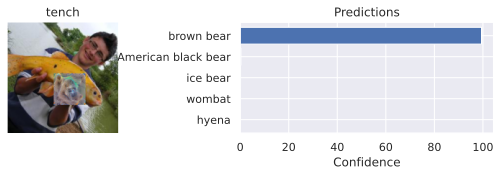

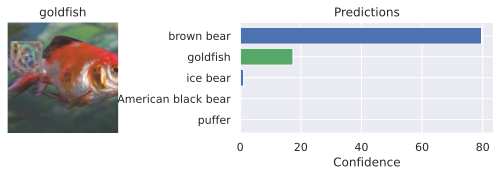

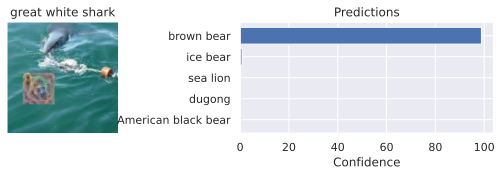

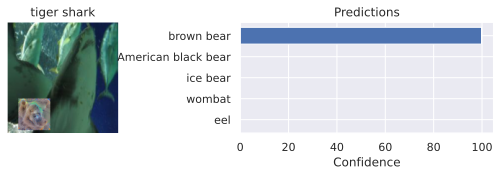

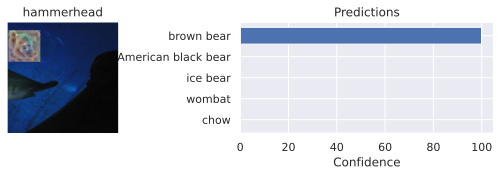

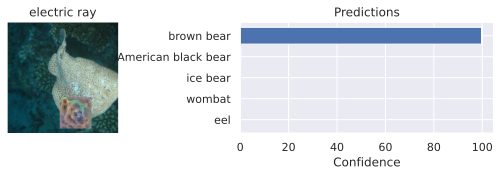

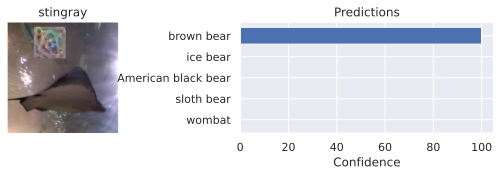

In [60]:
perform_patch_attack(patch_dict['brown bear'][64]['patch'])


All images were classified as brown bear with near-100% confidence, underscoring how vulnerable CNNs can be to adversarial manipulation.

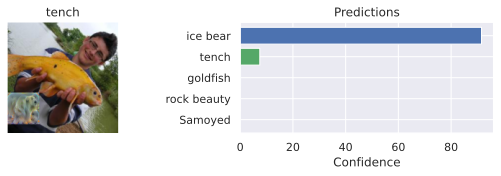

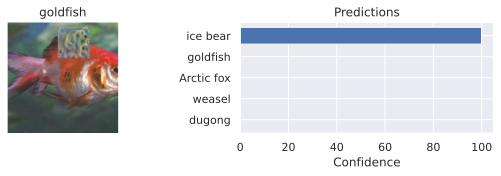

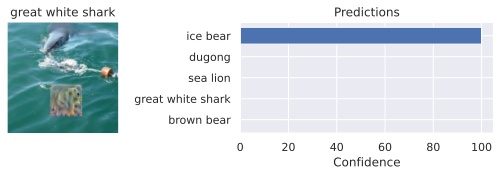

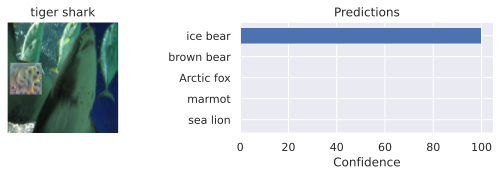

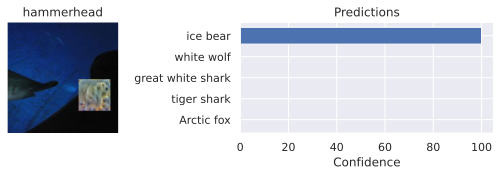

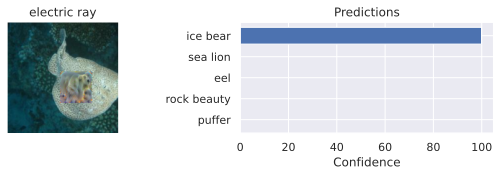

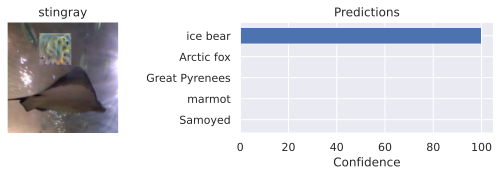

In [61]:
perform_patch_attack(patch_dict['ice bear'][64]['patch'])


Another example output of the adveserial attacks in the image to CNN model.

In [ ]:
# import os, torch, numpy as np
# from PIL import Image
# from torchvision import transforms
# from torchvision.utils import save_image

# # --- config: set this to True if your model expects ImageNet-normalized tensors ---
# NORMALIZED = True
# IMAGENET_MEAN = (0.485, 0.456, 0.406)
# IMAGENET_STD  = (0.229, 0.224, 0.225)



# preprocess_raw = transforms.Compose([
#     transforms.Resize(256),
#     transforms.CenterCrop(224),
#     transforms.ToTensor(),
# ])
# normalize = transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD)

# def load_images_from_dir(img_dir, max_images=None, normalized=NORMALIZED):
#     files = [os.path.join(img_dir, f) for f in os.listdir(img_dir)
#              if f.lower().endswith((".jpg", ".jpeg", ".png"))]
#     if not files:
#         raise RuntimeError(f"No images found in: {img_dir}")
#     if max_images is not None:
#         files = files[:max_images]

#     batch = []
#     for f in files:
#         pil = Image.open(f).convert("RGB")
#         t = preprocess_raw(pil)
#         if normalized:
#             t = normalize(t)
#         batch.append(t)
#     return torch.stack(batch, dim=0), files

# # Optional: denormalize for saving pretty PNGs
# def denormalize_img(t):
#     mean = torch.tensor(IMAGENET_MEAN).view(-1,1,1).to(t.device)
#     std  = torch.tensor(IMAGENET_STD ).view(-1,1,1).to(t.device)
#     return torch.clamp(t * std + mean, 0.0, 1.0)

# def save_patched_batch(patched_batch, out_dir, filenames=None, normalized=NORMALIZED):
#     os.makedirs(out_dir, exist_ok=True)
#     B = patched_batch.shape[0]
#     for i in range(B):
#         img_t = patched_batch[i].detach().cpu()
#         if normalized:
#             img_t = denormalize_img(img_t)
#         img_t = torch.clamp(img_t, 0.0, 1.0)
#         name = f"patched_{i}.png"
#         if filenames:
#             stem = os.path.splitext(os.path.basename(filenames[i]))[0]
#             name = f"{stem}__patched.png"
#         save_image(img_t, os.path.join(out_dir, name))


# img_dir = "./data"
# exmp_batch, file_list = load_images_from_dir(img_dir, normalized=NORMALIZED)

# label_batch = torch.zeros(len(file_list), dtype=torch.long)  # or adapt your show_prediction to accept None

# def perform_patch_attack_over_dir(patch, out_dir="./patched_from_my_pictures"):
#     global exmp_batch, label_batch
#     patch_batch = exmp_batch.clone()
#     patch_batch = place_patch(patch_batch, patch, save=False)

#     with torch.no_grad():
#         patch_preds = pretrained_model(patch_batch.to(device))

#     # show a few (if you use filenames, print them)
#     for i in range(0, min(len(patch_batch), 5)):
#         print("Pred for:", os.path.basename(file_list[i]))
#         try:
#             show_prediction(patch_batch[i], label_batch[i], patch_preds[i])
#         except Exception:
#             # Fallback: simple top-1 print if your show_prediction expects dataset labels
#             top1 = torch.argmax(patch_preds[i]).item()
#             print(" top1 idx:", top1)

#     # save the patched images as PNGs (denormalized if needed)
#     save_patched_batch(patch_batch, out_dir, filenames=file_list, normalized=NORMALIZED)
#     print(f"Saved patched images to: {out_dir}")



In [ ]:
# perform_patch_attack_over_dir(patch_dict['brown bear'][64]['patch'])

The code above aims to change the background images to intricate versions so model could have a hard time to detect with custom images.

## Conclusion

If such adversarial patches were used in the real world, they could create serious safety risks. For instance, imagine a smart surveillance system installed on farms or near houses that uses cameras to detect bears and trigger alarms. If someone placed a small adversarial image or sticker near the camera, it could trick the detection model into misclassifying anything as the bear as a result. This shows how fragile AI-based vision systems can be when faced with even small, intentional perturbations.